In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pickle
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Olympic Data.csv")

In [3]:
selected_col = ["Sex", "Age", "Height", "Weight", "region", "Sport", "Medal"]
df_temp = df[selected_col]

In [6]:
medal_dict = {np.nan: 0, "Gold": 1, "Silver": 1, "Bronze": 1}
df_temp["Medal"] = df_temp["Medal"].replace(medal_dict)

<ipython-input-6-afb4ec6b0229>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["Medal"] = df_temp["Medal"].replace(medal_dict)


In [7]:
medal_df = df_temp[df_temp["Medal"] == 1]
no_medal_df = df_temp[df_temp["Medal"] == 0].sample(len(medal_df), random_state=4)  # Sampling to balance
df_temp = pd.concat([medal_df, no_medal_df], axis=0)

In [8]:
# Imputation for missing values
avg_male_height = df_temp[df_temp["Sex"] == "M"]["Height"].mean()
avg_female_height = df_temp[df_temp["Sex"] == "F"]["Height"].mean()
avg_male_weight = df_temp[df_temp["Sex"] == "M"]["Weight"].mean()
avg_female_weight = df_temp[df_temp["Sex"] == "F"]["Weight"].mean()
avg_male_age = df_temp[df_temp["Sex"] == "M"]["Age"].mean()
avg_female_age = df_temp[df_temp["Sex"] == "F"]["Age"].mean()

In [9]:
# Filling NaN Values for Height, Weight, Age
df_temp.loc[df_temp["Sex"] == "M", "Height"] = df_temp.loc[df_temp["Sex"] == "M", "Height"].fillna(avg_male_height)
df_temp.loc[df_temp["Sex"] == "F", "Height"] = df_temp.loc[df_temp["Sex"] == "F", "Height"].fillna(avg_female_height)
df_temp.loc[df_temp["Sex"] == "M", "Weight"] = df_temp.loc[df_temp["Sex"] == "M", "Weight"].fillna(avg_male_weight)
df_temp.loc[df_temp["Sex"] == "F", "Weight"] = df_temp.loc[df_temp["Sex"] == "F", "Weight"].fillna(avg_female_weight)
df_temp.loc[df_temp["Sex"] == "M", "Age"] = df_temp.loc[df_temp["Sex"] == "M", "Age"].fillna(avg_male_age)
df_temp.loc[df_temp["Sex"] == "F", "Age"] = df_temp.loc[df_temp["Sex"] == "F", "Age"].fillna(avg_female_age)

df_temp.dropna(inplace=True)

In [10]:
X = df_temp.drop("Medal", axis=1)
y = df_temp["Medal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [11]:
# Preprocessing
transformer = ColumnTransformer(transformers=[
    ("num", StandardScaler(), ["Age", "Height", "Weight"]),
    ("cat", OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore"), ["Sex", "region", "Sport"])
], remainder="passthrough")

pipeline = Pipeline([
    ("preprocessor", transformer),
    ("pca", PCA(n_components=200))
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [12]:
# Logistic Regression Model
lr = LogisticRegression(solver="saga", max_iter=200)
lr.fit(X_train_transformed, y_train)
pickle.dump(lr, open("modellr.pkl", "wb"))

LogisticRegression(max_iter=200, solver='saga')

In [13]:
# RandomForestClassifier Model
rfc = RandomForestClassifier(n_estimators=100, random_state=4)
rfc.fit(X_train_transformed, y_train)
pickle.dump(rfc, open("modelrfc.pkl", "wb"))

RandomForestClassifier(random_state=4)

In [14]:
# Artificial Neural Network Model
model = Sequential()
model.add(Dense(64, activation="relu", input_shape=[200]))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0.001, patience=3, restore_best_weights=True
)

history = model.fit(X_train_transformed, y_train, epochs=10, validation_data=(X_test_transformed, y_test), callbacks=[earlystopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6112 - loss: 0.6902 - val_accuracy: 0.7092 - val_loss: 0.5625
Epoch 2/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6930 - loss: 0.5776 - val_accuracy: 0.7195 - val_loss: 0.5456
Epoch 3/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7092 - loss: 0.5596 - val_accuracy: 0.7251 - val_loss: 0.5359
Epoch 4/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7136 - loss: 0.5502 - val_accuracy: 0.7332 - val_loss: 0.5278
Epoch 5/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7231 - loss: 0.5401 - val_accuracy: 0.7310 - val_loss: 0.5245
Epoch 6/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7276 - loss: 0.5351 - val_accuracy: 0.7331 - val_loss: 0.5232
Epoch 7/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7312 - loss: 0.5313 - val_accuracy: 0.7362 - val_loss: 0.5204
Epoch 8/10
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7271 - loss: 0.530

In [ ]:
pickle.dump(model, open("modelnn.pkl", "wb"))

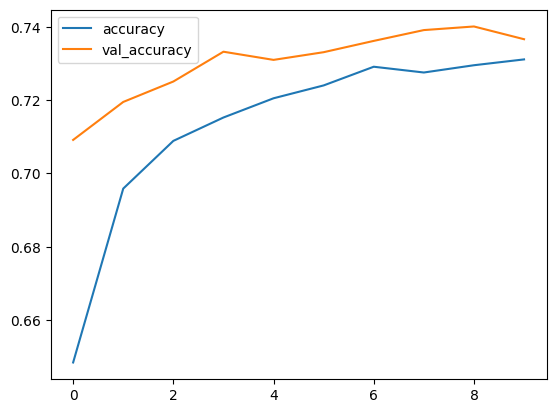

In [15]:
# Plotting the training vs validation accuracy for the neural network
df_plot = pd.DataFrame(history.history)
df_plot[["accuracy", "val_accuracy"]].plot()
plt.legend()
plt.show()

In [18]:
# Function to Evaluate Models
def evaluate_model(predictions, y_test):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{cm}")

# Evaluate Logistic Regression
print("Logistic Regression Evaluation:")
evaluate_model(lr.predict(X_test_transformed), y_test)

# Evaluate RandomForestClassifier
print("\nRandomForestClassifier Evaluation:")
evaluate_model(rfc.predict(X_test_transformed), y_test)

# Evaluate Neural Network
print("\nNeural Network Evaluation:")
nn_predictions = (model.predict(X_test_transformed) > 0.5).astype("int32")
evaluate_model(nn_predictions, y_test)


Logistic Regression Evaluation:
Accuracy: 0.6811594202898551
Precision: 0.6773240193444384
Recall: 0.6720874433484404
F1 Score: 0.6746955707212632
Confusion Matrix:
[[5345 2402]
 [2460 5042]]

RandomForestClassifier Evaluation:
Accuracy: 0.7518525804970818
Precision: 0.7431972789115646
Recall: 0.7572647294054918
F1 Score: 0.7501650600818698
Confusion Matrix:
[[5784 1963]
 [1821 5681]]

Neural Network Evaluation:
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.7391304347826086
Precision: 0.7279430789133247
Recall: 0.7500666488936284
F1 Score: 0.7388392857142857
Confusion Matrix:
[[5644 2103]
 [1875 5627]]
